In [1]:
#ml and plotting imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

## Cams Ancient Greek Morphosyntactic Analyser — Verb Parser

In [6]:
#filesystem and xml imports
import os
import sys
import csv
from pathlib import Path
from typing import Dict, Tuple, Iterable
# XML parser you use to read the PAULA files and the chronology and URN tables
from lxml import etree

In [7]:
#optional: do this to set oga dataset path instead of running terminal command
#"export OGA_ROOT=/Users/admin/Desktop/opera_graeca_verb_parser/opera_graeca_adnotata/opera_graeca_adnotata_v0.2.0"


os.environ["OGA_ROOT"] = "/Users/admin/Desktop/opera_graeca_verb_parser/opera_graeca_adnotata/opera_graeca_adnotata_v0.2.0"

#### Load and extract verb data from texts

In [8]:
# Set corpus and project paths and prepare the data directory.

oga_root = os.environ.get("OGA_ROOT")
if oga_root is None:
    raise RuntimeError(
        "OGA_ROOT environment variable is not set. "
        "Export OGA_ROOT=/full/path/to/opera_graeca_adnotata_v0.2.0 before running this notebook."
    )

opera_graeca = Path(oga_root).expanduser().resolve()
if not opera_graeca.exists():
    raise RuntimeError(f"OGA_ROOT path does not exist: {opera_graeca}")

project_root = Path.cwd().resolve()

data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

XLINK = "{http://www.w3.org/1999/xlink}href"

VOICE_LABEL_MAP = {
    "active": 0,
    "middle": 1,
    "passive": 2,
    "medio-passive": 3,
}

# save for later
# PERSON_LABEL_MAP = {}
# NUMBER_LABEL_MAP = {}
# TENSE_LABEL_MAP = {}
# MOOD_LABEL_MAP = {}


In [9]:
# Define helper functions to read OGA metadata, chronology, and URN tables.

def base_from_urn(urn: str) -> str:
    """
    Reduce a full CTS URN to a base work URN.

    Example
        tlg0003.tlg001.perseus-grc1 becomes tlg0003.tlg001
    """
    if not urn:
        return ""
    parts = urn.split(".")
    return ".".join(parts[:2]) if len(parts) >= 2 else urn


# PAULA functions in workspace and oga.
# These read per work PAULA XML sidecars under workspace and oga.

def iter_token_files(opera_root: Path) -> Iterable[Path]:
    """
    Yield all tokenization files TEXT_ID.tok01.xml under workspace and oga.

    Example path yielded
        OGA_ROOT/workspace/oga/oga_v0.2.0_1/.../TEXT_ID.tok01.xml
    """
    base = opera_root / "workspace" / "oga"
    if not base.exists():
        raise FileNotFoundError(f"PAULA workspace not found at {base}")

    for path in base.rglob("*.tok01.xml"):
        # Skip morphological layer files like postag.*.tok01_postag01.xml
        if path.name.startswith("postag."):
            continue
        yield path


def load_lemma_map(lemma_path: Path) -> Dict[str, str]:
    """
    Load a token id to lemma mapping from one lemma layer file.

    In that file each feat under featList has attributes
    xlink:href for example #t_7 and value for example γίγνομαι.
    """
    if not lemma_path.exists():
        return {}

    tree = etree.parse(str(lemma_path))
    root = tree.getroot()
    fl = root.find("featList")
    if fl is None:
        return {}

    mapping: Dict[str, str] = {}
    for feat in fl.findall("feat"):
        href = feat.attrib.get(XLINK)
        if not href or not href.startswith("#"):
            continue
        tok_id = href[1:]
        lemma = feat.attrib.get("value", "")
        mapping[tok_id] = lemma

    return mapping


def get_work_metadata_from_anno(token_path: Path) -> Dict[str, str]:
    """
    Read work level metadata for one work from PAULA sidecar files
    stored in the same directory as the token file.
    """
    work_dir = token_path.parent

    def read_one(name: str) -> str:
        p = work_dir / name
        if not p.exists():
            return ""
        t = etree.parse(str(p))
        r = t.getroot()
        fl = r.find("featList")
        if fl is None:
            return ""
        feat = fl.find("feat")
        if feat is None:
            return ""
        return feat.attrib.get("value", "")

    work_urn_full = read_one("anno_urn_cts.xml")
    work_urn_base = base_from_urn(work_urn_full)
    local_work_id = read_one("anno_urn_cts_work.xml")

    return {
        "work_urn_full": work_urn_full,
        "work_urn_base": work_urn_base,
        "local_work_id": local_work_id,
        "edition_urn": read_one("anno_urn_cts_edition.xml"),
        "author_urn": read_one("anno_urn_cts_author.xml"),
        "title": read_one("anno_title.xml"),
        "author_name": read_one("anno_author.xml"),
        "work_date_annotation": read_one("anno_work_date.xml"),
    }


# Chronology functions at work_chronology and texts.
# These interpret work level date information from the chronology file.

def parse_year_range(formatted: str):
    """
    Parse a formatted_work_date string into a pair of years.

    Examples of formatted strings
        -400/-350, 50/100, +50/+100.

    Returns a pair start_year and end_year as integers or a pair of None values.
    """
    if not formatted:
        return None, None

    text = formatted.replace("—", "-").strip()

    try:
        left, right = text.split("/")
    except ValueError:
        return None, None

    def parse_one(s: str):
        s = s.strip()
        if not s:
            return None
        sign = -1 if s.startswith("-") else 1
        if s[0] in "+-":
            s = s[1:]
        s = s.split("-")[0]
        try:
            year = int(s)
        except ValueError:
            return None
        return sign * year

    y1 = parse_one(left)
    y2 = parse_one(right)
    if y1 is None or y2 is None:
        return None, None
    return y1, y2


def load_chronology_map(opera_root: Path) -> Dict[str, Dict[str, object]]:
    """
    Load work chronology keyed by base work URN.

    Reads the file
        work_chronology/texts/chronology_greek_works_plus_date_label.xml.
    """
    chron_path = (
        opera_root
        / "work_chronology"
        / "texts"
        / "chronology_greek_works_plus_date_label.xml"
    )
    if not chron_path.exists():
        raise FileNotFoundError(f"Chronology file not found at {chron_path}")

    tree = etree.parse(str(chron_path))
    root = tree.getroot()

    out: Dict[str, Dict[str, object]] = {}
    for rec in root.findall(".//record"):
        urn_el = rec.find("urn_cts")
        fmt_el = rec.find("formatted_work_date")
        lab_el = rec.find("date_label")

        urn_cts = urn_el.text.strip() if urn_el is not None and urn_el.text else ""
        if not urn_cts:
            continue

        formatted = fmt_el.text.strip() if fmt_el is not None and fmt_el.text else ""
        label = lab_el.text.strip() if lab_el is not None and lab_el.text else ""

        base = base_from_urn(urn_cts)
        y1, y2 = parse_year_range(formatted)
        year_mid = (y1 + y2) / 2.0 if y1 is not None and y2 is not None else None

        out[base] = {
            "formatted_work_date": formatted,
            "date_label": label,
            "year_mid": year_mid,
        }

    return out


# URN functions at urn_cts and texts.
# These read the URN master list from urn_cts and texts and urn_cts.xml.

def load_urn_cts_table(opera_root: Path) -> Dict[str, Dict[str, str]]:
    """
    Load the URN table as a dictionary keyed by full work URN.

    Reads the file
        urn_cts/texts/urn_cts.xml.
    """
    urn_path = opera_root / "urn_cts" / "texts" / "urn_cts.xml"
    if not urn_path.exists():
        raise FileNotFoundError(f"URN table not found at {urn_path}")

    tree = etree.parse(str(urn_path))
    root = tree.getroot()

    table: Dict[str, Dict[str, str]] = {}
    for rec in root.findall(".//record"):
        urn_el = rec.find("urn_cts")
        if urn_el is None or not urn_el.text:
            continue
        full_urn = urn_el.text.strip()
        meta: Dict[str, str] = {"base_urn": base_from_urn(full_urn)}

        for child in rec:
            if child is urn_el:
                continue
            if child.text:
                meta[child.tag] = child.text.strip()

        table[full_urn] = meta

    return table


In [78]:
# Extract verb tokens from OGA and build the verb table.

def interpret_voice(code: str) -> str:
    """
    Map a voice code from the OGA morph layer to a readable label.
    """
    if code == "a":
        return "active"
    if code == "m":
        return "middle"
    if code == "p":
        return "passive"
    if code == "e":
        return "medio-passive"
    return ""


def extract_verbs_from_work(
    token_path: Path,
    chron_map: Dict[str, Dict[str, object]],
) -> list[dict]:
    """
    Extract verb tokens and metadata for a single work.
    """
    work_dir = token_path.parent
    stem = token_path.stem
    if not stem.endswith(".tok01"):
        return []

    text_id = stem[: -len(".tok01")]

    lemma_path = work_dir / f"{text_id}.tok01_lemma01.xml"
    postag_path = work_dir / f"postag.{text_id}.tok01_postag01.xml"
    if not lemma_path.exists() or not postag_path.exists():
        return []

    meta = get_work_metadata_from_anno(token_path)
    work_urn_base = meta.get("work_urn_base", "")

    chron_info = chron_map.get(work_urn_base, {})
    formatted_work_date = chron_info.get("formatted_work_date", "")
    date_label = chron_info.get("date_label", "")
    year_mid = chron_info.get("year_mid", None)

    lemma_map = load_lemma_map(lemma_path)

    tree = etree.parse(str(postag_path))
    root = tree.getroot()
    mfl = root.find("multiFeatList")
    if mfl is None:
        return []

    rows: list[dict] = []

    for mf in mfl.findall("multiFeat"):
        href = mf.attrib.get(XLINK)
        if not href or not href.startswith("#"):
            continue
        token_id = href[1:]

        cats = {}
        for f in mf.findall("feat"):
            name = f.attrib.get("name")
            val = f.attrib.get("value")
            if name and val:
                cats[name] = val

        if cats.get("pos") != "v":
            continue

        voice_code = cats.get("voice", "")
        voice_name = interpret_voice(voice_code)
        voice_label = VOICE_LABEL_MAP.get(voice_name, -1)

        row = {
            "work_urn_base": work_urn_base,
            "work_urn_full": meta.get("work_urn_full", ""),
            "edition_urn": meta.get("edition_urn", ""),
            "author_urn": meta.get("author_urn", ""),
            "author_name": meta.get("author_name", ""),
            "title": meta.get("title", ""),
            "work_date_annotation": meta.get("work_date_annotation", ""),
            "formatted_work_date": formatted_work_date,
            "date_label": date_label,
            "year_mid": year_mid,
            "token_id": token_id,
            "lemma": lemma_map.get(token_id, ""),
            "pos": cats.get("pos", ""),
            "person": cats.get("person", ""),
            "number": cats.get("number", ""),
            "tense": cats.get("tense", ""),
            "mood": cats.get("mood", ""),
            "voice": voice_name,
            "voice_label": voice_label,
        }

        rows.append(row)

    return rows


def build_verb_table(opera_root: Path, out_dir: Path) -> pd.DataFrame:
    """
    Walk the OGA workspace, extract verbs for all works, attach chronology, and write a TSV.
    """
    chron_map = load_chronology_map(opera_root)

    all_rows: list[dict] = []
    work_count = 0
    verb_count = 0

    token_files = list(iter_token_files(opera_root))
    total_works = len(token_files)
    print(f"found {total_works} token files in workspace/oga")

    for idx, token_path in enumerate(token_files, start=1):
        per_work_rows = extract_verbs_from_work(token_path, chron_map)
        if per_work_rows:
            all_rows.extend(per_work_rows)
            work_count += 1
            verb_count += len(per_work_rows)

        if idx % 50 == 0 or idx == total_works:
            print(
                f"processed {idx}/{total_works} token files "
                f"({work_count} works with verbs, {verb_count} verb tokens so far)"
            )

    columns = [
        "work_urn_base",
        "work_urn_full",
        "edition_urn",
        "author_urn",
        "author_name",
        "title",
        "work_date_annotation",
        "formatted_work_date",
        "date_label",
        "year_mid",
        "token_id",
        "lemma",
        "pos",
        "person",
        "number",
        "tense",
        "mood",
        "voice",
        "voice_label",
    ]

    df = pd.DataFrame(all_rows)

    for col in columns:
        if col not in df.columns:
            df[col] = ""

    df = df[columns]

    out_path = out_dir / "oga_verbs_voice_metadata.tsv"
    df.to_csv(out_path, sep="\t", index=False)

    print(f"wrote {verb_count} verb tokens from {work_count} works to {out_path}")
    return df


In [79]:
# Run extraction and preview the first rows.

verb_df = build_verb_table(opera_graeca, data_dir)
verb_df.head(25)


found 3998 token files in workspace/oga
processed 50/3998 token files (50 works with verbs, 194322 verb tokens so far)
processed 100/3998 token files (100 works with verbs, 291608 verb tokens so far)
processed 150/3998 token files (150 works with verbs, 393380 verb tokens so far)
processed 200/3998 token files (200 works with verbs, 491638 verb tokens so far)
processed 250/3998 token files (250 works with verbs, 570268 verb tokens so far)
processed 300/3998 token files (300 works with verbs, 733220 verb tokens so far)
processed 350/3998 token files (350 works with verbs, 801681 verb tokens so far)
processed 400/3998 token files (400 works with verbs, 910910 verb tokens so far)
processed 450/3998 token files (450 works with verbs, 1277771 verb tokens so far)
processed 500/3998 token files (500 works with verbs, 1720994 verb tokens so far)
processed 550/3998 token files (550 works with verbs, 2037589 verb tokens so far)
processed 600/3998 token files (600 works with verbs, 2384883 verb t

,work_urn_base,work_urn_full,edition_urn,author_urn,author_name,title,work_date_annotation,formatted_work_date,date_label,year_mid,token_id,lemma,pos,person,number,tense,mood,voice,voice_label
0,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_1,αἰάζω,v,1,s,p,i,active,0
1,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_5,ἀπόλλυμι,v,3,s,a,i,middle,1
2,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_9,ὄλλυμι,v,3,s,a,i,middle,1
3,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_12,ἐπαιάζω,v,3,p,p,i,active,0
4,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_20,καθεύδω,v,2,s,p,m,active,0
5,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_22,ἐγείρω,v,2,s,a,m,middle,1
6,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_27,πλατάγης,v,2,s,a,m,active,0
7,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_30,λέγω3,v,2,s,p,m,active,0
8,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_32,ἀπόλλυμι,v,3,s,a,i,middle,1
9,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_36,αἰάζω,v,1,s,p,i,active,0


In [84]:
# Load extracted verb table from TSV.

tsv_path = data_dir / "oga_verbs_voice_metadata.tsv"
verb_df = pd.read_csv(tsv_path, sep="\t")

print("rows after load:", len(verb_df))
verb_df.head(25)


rows after load: 6083134


,work_urn_base,work_urn_full,edition_urn,author_urn,author_name,title,work_date_annotation,formatted_work_date,date_label,year_mid,token_id,lemma,pos,person,number,tense,mood,voice,voice_label
0,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_1,αἰάζω,v,1.0,s,p,i,active,0
1,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_5,ἀπόλλυμι,v,3.0,s,a,i,middle,1
2,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_9,ὄλλυμι,v,3.0,s,a,i,middle,1
3,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_12,ἐπαιάζω,v,3.0,p,p,i,active,0
4,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_20,καθεύδω,v,2.0,s,p,m,active,0
5,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_22,ἐγείρω,v,2.0,s,a,m,middle,1
6,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_27,πλατάγης,v,2.0,s,a,m,active,0
7,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_30,λέγω3,v,2.0,s,p,m,active,0
8,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_32,ἀπόλλυμι,v,3.0,s,a,i,middle,1
9,tlg0036.tlg001,tlg0036.tlg001.perseus-grc2,perseus-grc2,tlg0036,Bion of Phlossa,Epitaphius Adonis,m2_2/m1_1,—0124-01/—0074-12,m2_2/m1_1,-99.0,t_36,αἰάζω,v,1.0,s,p,i,active,0


### Raw count verb plots

#### matplotlib pivot tables verb voice raw counts

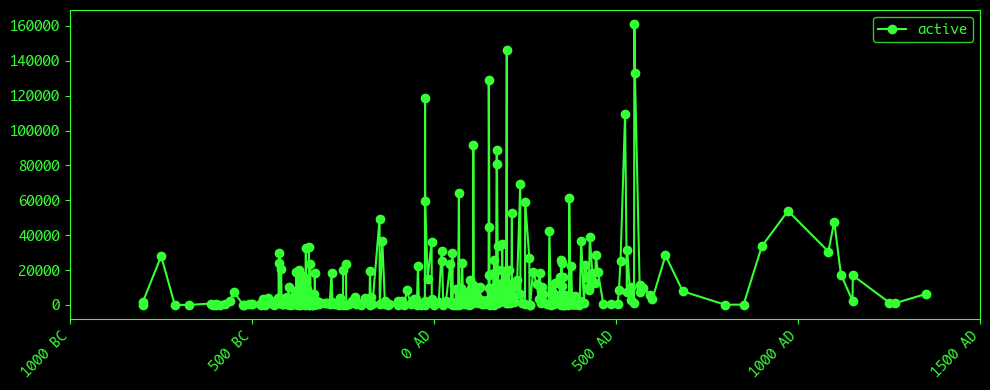

saved count plot for active to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_counts_active.png


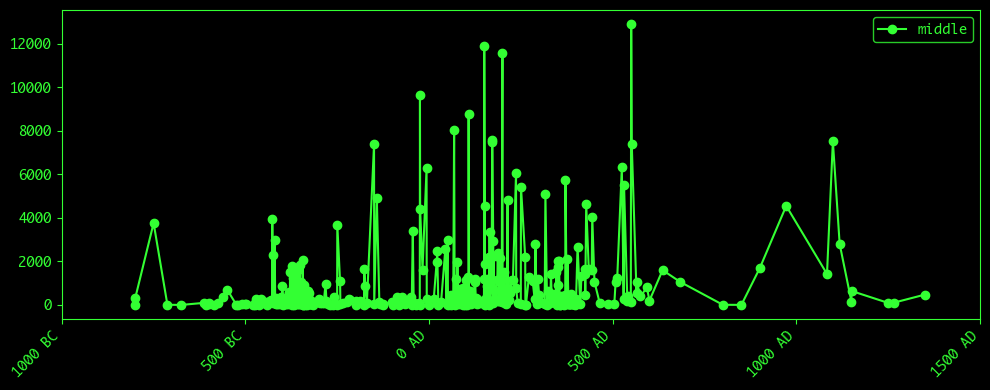

saved count plot for middle to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_counts_middle.png


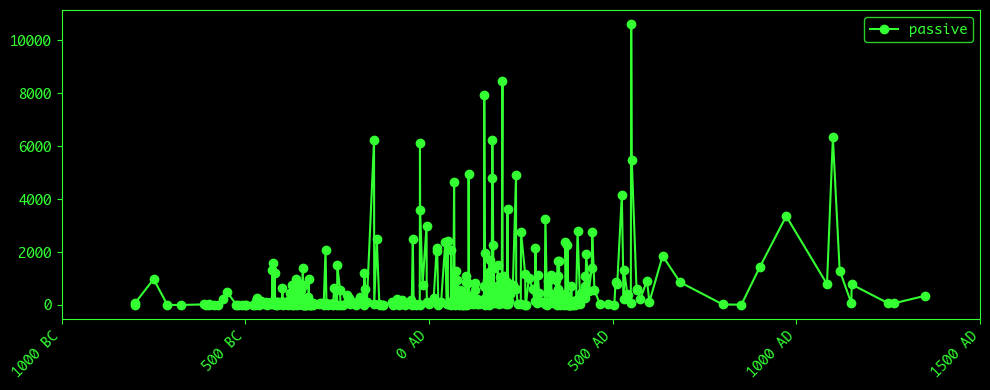

saved count plot for passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_counts_passive.png


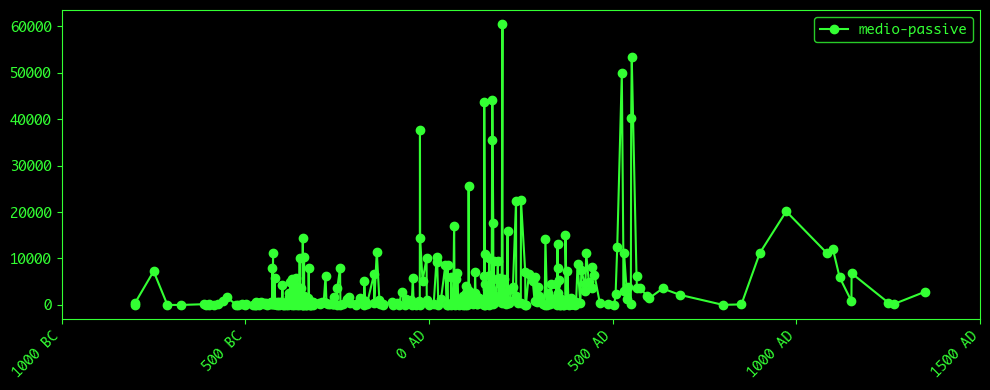

saved count plot for medio-passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_counts_medio-passive.png


In [38]:
# Prepare counts per voice over time, plot one graph per voice, and save PNG files.

verb_df_year = verb_df.dropna(subset=["year_mid"]).copy()
verb_df_year["year_mid"] = verb_df_year["year_mid"].astype(float)

work_voice_counts = (
    verb_df_year
    .groupby(["work_urn_base", "year_mid", "voice"], dropna=False)
    .size()
    .reset_index(name="count")
)

year_voice_counts = (
    work_voice_counts
    .groupby(["year_mid", "voice"])["count"]
    .sum()
    .reset_index()
)

pivot = (
    year_voice_counts
    .pivot_table(
        index="year_mid",
        columns="voice",
        values="count",
        aggfunc="sum",
        fill_value=0,
    )
    .sort_index()
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Monaco", "Courier", "Courier New", "DejaVu Sans Mono"]

voice_order = ["active", "middle", "passive", "medio-passive"]

for voice in voice_order:
    if voice not in pivot.columns:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))

    fig.patch.set_facecolor("#000000")
    ax.set_facecolor("#000000")

    ax.plot(
        pivot.index,
        pivot[voice],
        marker="o",
        linestyle="-",
        color="#33FF33",
        label=voice,
    )

    for spine in ax.spines.values():
        spine.set_color("#33FF33")

    ax.tick_params(colors="#33FF33")

    ticks = ax.get_xticks()
    labels = []
    for t in ticks:
        year = int(round(t))
        if year < 0:
            labels.append(f"{abs(year)} BC")
        else:
            labels.append(f"{year} AD")

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha="right", color="#33FF33")

    legend = ax.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor("#000000")
    frame.set_edgecolor("#33FF33")

    for text in legend.get_texts():
        text.set_color("#33FF33")

    for legline in legend.get_lines():
        legline.set_color("#33FF33")

    plt.tight_layout()

    out_path = data_dir / f"verb_voice_counts_{voice}.png"
    fig.savefig(
        out_path,
        dpi=300,
        facecolor=fig.get_facecolor(),
        bbox_inches="tight",
    )

    plt.show()
    print(f"saved count plot for {voice} to {out_path}")


#### matplotlib pivot tables verb voice proportional

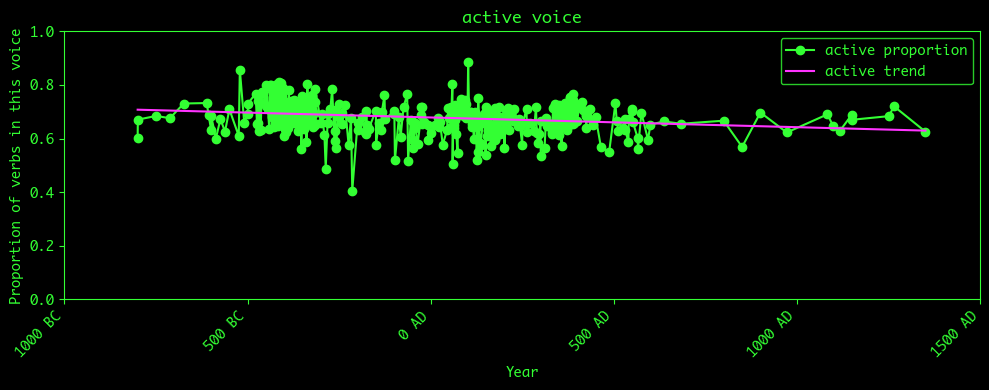

saved plot for active to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_proportion_active.png


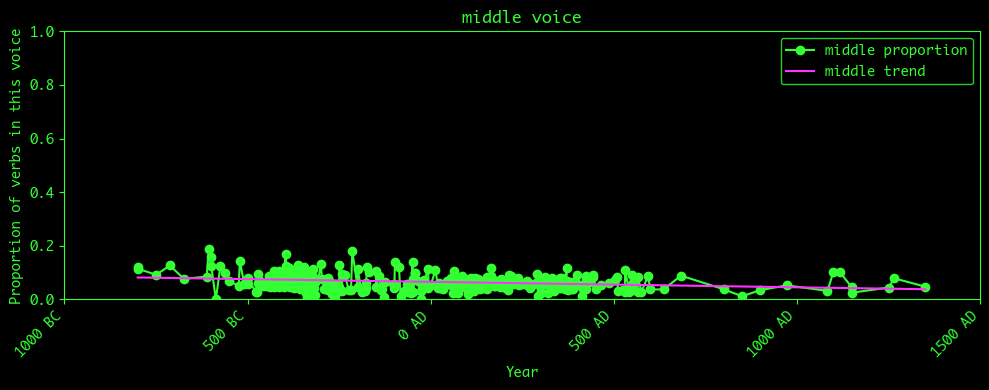

saved plot for middle to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_proportion_middle.png


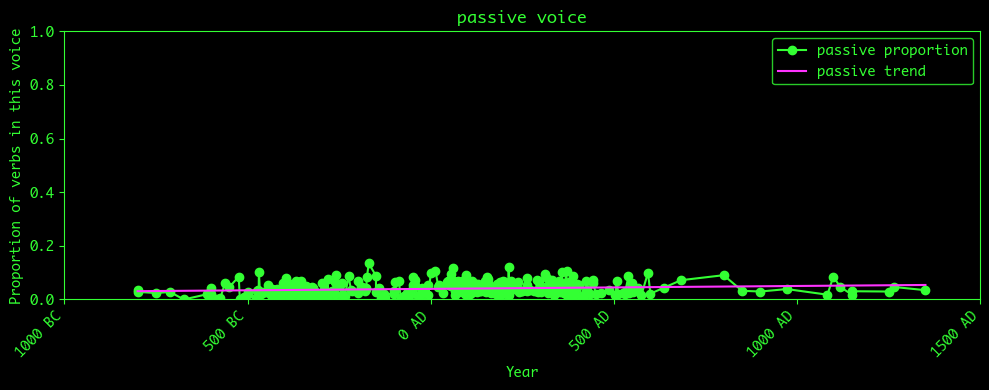

saved plot for passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_proportion_passive.png


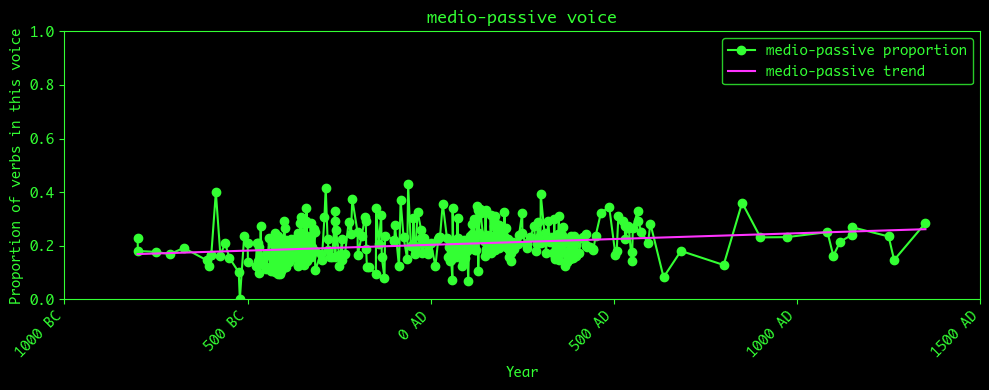

saved plot for medio-passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_proportion_medio-passive.png


In [35]:
# Plot proportions per voice over time with straight trend lines and save one PNG per voice.

verb_df_year = verb_df.dropna(subset=["year_mid"]).copy()
verb_df_year["year_mid"] = verb_df_year["year_mid"].astype(float)

year_voice_counts = (
    verb_df_year
    .groupby(["year_mid", "voice"], dropna=False)
    .size()
    .reset_index(name="count")
)

year_totals = (
    verb_df_year
    .groupby("year_mid", dropna=False)
    .size()
    .reset_index(name="total")
)

year_props = year_voice_counts.merge(year_totals, on="year_mid", how="left")
year_props["proportion"] = year_props["count"] / year_props["total"]

pivot = (
    year_props
    .pivot_table(
        index="year_mid",
        columns="voice",
        values="proportion",
        aggfunc="mean",
        fill_value=0.0,
    )
    .sort_index()
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Monaco", "Courier", "Courier New", "DejaVu Sans Mono"]

voice_order = ["active", "middle", "passive", "medio-passive"]

for voice in voice_order:
    if voice not in pivot.columns:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))

    fig.patch.set_facecolor("#000000")
    ax.set_facecolor("#000000")

    x = pivot.index.values.astype(float)
    y = pivot[voice].values.astype(float)

    ax.plot(
        x,
        y,
        marker="o",
        linestyle="-",
        color="#33FF33",
        label=f"{voice} proportion",
    )

    if len(x) >= 2 and np.any(y != y[0]):
        m, b = np.polyfit(x, y, 1)
        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = m * x_fit + b
        ax.plot(
            x_fit,
            y_fit,
            linestyle="-",
            color="#FF33FF",
            label=f"{voice} trend",
        )

    for spine in ax.spines.values():
        spine.set_color("#33FF33")

    ax.tick_params(colors="#33FF33")

    ticks = ax.get_xticks()
    labels = []
    for t in ticks:
        year = int(round(t))
        if year < 0:
            labels.append(f"{abs(year)} BC")
        else:
            labels.append(f"{year} AD")

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha="right", color="#33FF33")

    ax.set_ylim(0.0, 1.0)

    ax.set_xlabel("Year", color="#33FF33")
    ax.set_ylabel("Proportion of verbs in this voice", color="#33FF33")
    ax.set_title(f"{voice} voice", color="#33FF33")

    legend = ax.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor("#000000")
    frame.set_edgecolor("#33FF33")

    for text in legend.get_texts():
        text.set_color("#33FF33")

    for legline in legend.get_lines():
        legline.set_color(legline.get_color())

    plt.tight_layout()

    out_path = data_dir / f"verb_voice_proportion_{voice}.png"
    fig.savefig(
        out_path,
        dpi=300,
        facecolor=fig.get_facecolor(),
        bbox_inches="tight",
    )

    plt.show()
    print(f"saved plot for {voice} to {out_path}")


#### plot all four verbs same plot proportional

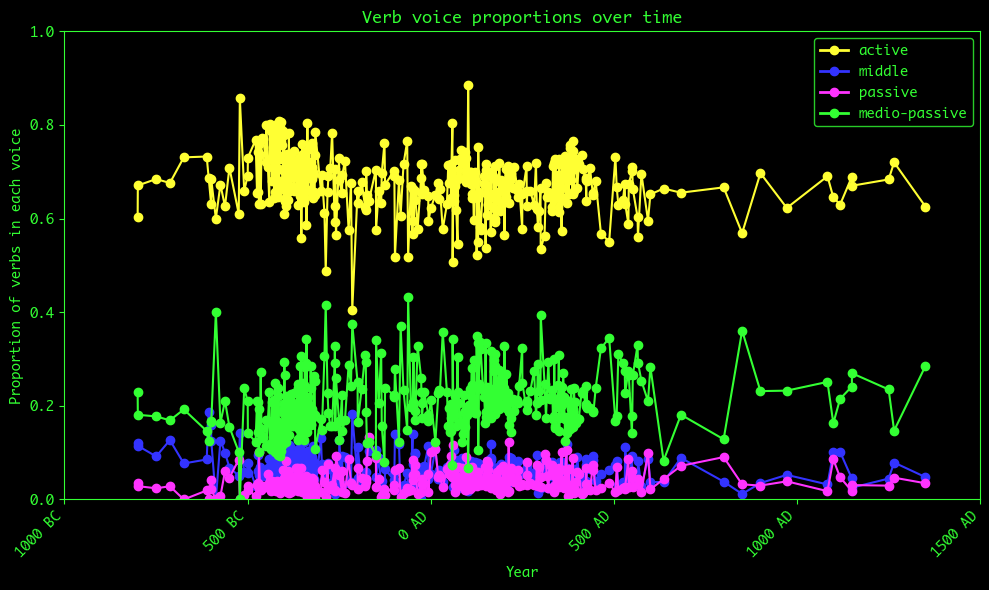

saved plot to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_voice_proportions_all_voices.png


In [36]:
# Plot proportions for all voices on one graph and save a combined PNG.

verb_df_year = verb_df.dropna(subset=["year_mid"]).copy()
verb_df_year["year_mid"] = verb_df_year["year_mid"].astype(float)

year_voice_counts = (
    verb_df_year
    .groupby(["year_mid", "voice"], dropna=False)
    .size()
    .reset_index(name="count")
)

year_totals = (
    verb_df_year
    .groupby("year_mid", dropna=False)
    .size()
    .reset_index(name="total")
)

year_props = year_voice_counts.merge(year_totals, on="year_mid", how="left")
year_props["proportion"] = year_props["count"] / year_props["total"]

pivot = (
    year_props
    .pivot_table(
        index="year_mid",
        columns="voice",
        values="proportion",
        aggfunc="mean",
        fill_value=0.0,
    )
    .sort_index()
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Monaco", "Courier", "Courier New", "DejaVu Sans Mono"]

fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_facecolor("#000000")
ax.set_facecolor("#000000")

voice_colors = {
    "active": "#FFFF33",
    "middle": "#3333FF",
    "passive": "#FF33FF",
    "medio-passive": "#33FF33",
}

for voice, color in voice_colors.items():
    if voice not in pivot.columns:
        continue
    x = pivot.index.values.astype(float)
    y = pivot[voice].values.astype(float)
    ax.plot(
        x,
        y,
        marker="o",
        linestyle="-",
        color=color,
        label=voice,
    )

for spine in ax.spines.values():
    spine.set_color("#33FF33")

ax.tick_params(colors="#33FF33")

ticks = ax.get_xticks()
labels = []
for t in ticks:
    year = int(round(t))
    if year < 0:
        labels.append(f"{abs(year)} BC")
    else:
        labels.append(f"{year} AD")

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha="right", color="#33FF33")

ax.set_ylim(0.0, 1.0)

ax.set_xlabel("Year", color="#33FF33")
ax.set_ylabel("Proportion of verbs in each voice", color="#33FF33")
ax.set_title("Verb voice proportions over time", color="#33FF33")

legend = ax.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor("#000000")
frame.set_edgecolor("#33FF33")

for text in legend.get_texts():
    text.set_color("#33FF33")

for legline in legend.get_lines():
    legline.set_linewidth(2.0)

plt.tight_layout()

out_path = data_dir / "verb_voice_proportions_all_voices.png"
fig.savefig(
    out_path,
    dpi=300,
    facecolor=fig.get_facecolor(),
    bbox_inches="tight",
)

plt.show()
print(f"saved plot to {out_path}")


### Build X and y training data from verb_df

In [111]:
# Build training features X and labels y from the extracted verb table.

# Keep only rows with valid voice labels 0, 1, 2, 3.
verb_df_clean = verb_df[verb_df["voice_label"].isin([0, 1, 2, 3])].copy()
verb_df_clean.reset_index(drop=True, inplace=True)
print("training rows verb_df_clean:", len(verb_df_clean))

# Check label distribution in cleaned df.
print(verb_df_clean["voice_label"].value_counts())



input_cols = ["person", "number", "tense", "mood"]

# Encode missing conjugation information as an explicit category.
verb_df_clean[input_cols] = verb_df_clean[input_cols].fillna("MISSING")

# One hot encode conjugation categories.
X_df = pd.get_dummies(verb_df_clean[input_cols], dummy_na=False)

# NumPy arrays.
X = X_df.to_numpy().astype("float32")
y = verb_df_clean["voice_label"].to_numpy().astype("int32")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("any NaN in X:", np.isnan(X).any())
print("any NaN in y:", np.isnan(y).any())

# Save feature and label arrays to the data directory.
X_out = data_dir / "X_verb_features.npy"
y_out = data_dir / "y_voice_labels.npy"
np.save(X_out, X)
np.save(y_out, y)

print("saved X to", X_out)
print("saved y to", y_out)


training rows verb_df_clean: 6010530
voice_label
0    4052413
3    1324812
1     380105
2     253200
Name: count, dtype: int64
X shape: (6010530, 24)
y shape: (6010530,)
any NaN in X: False
any NaN in y: False
saved X to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/X_verb_features.npy
saved y to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/y_voice_labels.npy


### Tensorflow Code

In [112]:
# Define the TensorFlow model for voice classification.

num_features = X.shape[1]
num_classes = 4
hidden_units = 64

# X 
# first hidden layer using sigmoid fxn
# second linear layer then softmax
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(num_features,)),
        tf.keras.layers.Dense(hidden_units, activation="sigmoid"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()
print("model compiled")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,860 (7.27 KB)

 Trainable params: 1,860 (7.27 KB)

 Non-trainable params: 0 (0.00 B)

model compiled


In [113]:
#check y
print("unique y labels and counts at training time:")
vals, counts = np.unique(y, return_counts=True)
for v, c in zip(vals, counts):
    print(int(v), int(c))
print("sum counts:", int(counts.sum()))

unique y labels and counts at training time:
0 4052413
1 380105
2 253200
3 1324812
sum counts: 6010530


In [114]:
# Train the model and save the final softmax head parameters.
# Computes h = σ(W_1 x + b_1) in the hidden layer.
# Computes z = W_2 h + b_2 in the output layer.
#computes the softmax probabilities and cross entropy loss against y
#computes gradients and updates W_2,b_2,W_2,b_2

# model is a tf.keras model already defined above, with final Dense(4, activation="softmax")
# train / fit and save final linear parameters for the voice head


history = model.fit(
    X,
    y,
    batch_size=256,
    epochs=10,
    validation_split=0.1,
    shuffle=True,
)

# extract W and b from the last Dense layer (softmax head)
last_layer = model.layers[-1]
W, b = last_layer.get_weights()  # W shape (hidden_units, 4), b shape (4,)

# save parameters to project root
W_out = data_dir / "voice_head_weights.npy"
b_out = data_dir / "voice_head_bias.npy"
np.save(W_out, W)
np.save(b_out, b)

print("W shape:", W.shape, "saved to", W_out)
print("b shape:", b.shape, "saved to", b_out)

#check train accuracy
train_loss, train_acc = model.evaluate(X, y, verbose=0)
print("train accuracy:", train_acc)

Epoch 1/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 477us/step - accuracy: 0.6850 - loss: 0.6998 - val_accuracy: 0.7077 - val_loss: 0.6978
Epoch 2/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 470us/step - accuracy: 0.6864 - loss: 0.6937 - val_accuracy: 0.7087 - val_loss: 0.6964
Epoch 3/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 465us/step - accuracy: 0.6865 - loss: 0.6929 - val_accuracy: 0.7085 - val_loss: 0.6972
Epoch 4/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 469us/step - accuracy: 0.6865 - loss: 0.6926 - val_accuracy: 0.7047 - val_loss: 0.6980
Epoch 5/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 471us/step - accuracy: 0.6866 - loss: 0.6924 - val_accuracy: 0.7053 - val_loss: 0.6973
Epoch 6/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 478us/step - accuracy: 0.6866 - loss: 0.6922 - val_accuracy: 0.7091 - val_loss: 0.6950
Epoch 7/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 469us/step - accuracy: 0.6866 - loss: 0.6921 - val_accuracy: 0.7050 - val_loss: 0.6970
Epoch 8/10
21131/21131 ━━━━━━━━━━━━━━━━━━━━ 10s 466us/s

In [116]:
# Run inference on the training features and save predictions as a TSV.

probs = model.predict(X, batch_size=256)

pred_voice_label = np.argmax(probs, axis=1)

verb_df_pred = verb_df_clean.copy()
verb_df_pred["pred_voice_label"] = pred_voice_label

inv_voice_map = {v: k for (k, v) in VOICE_LABEL_MAP.items()}
verb_df_pred["pred_voice_name"] = verb_df_pred["pred_voice_label"].map(inv_voice_map)


pred_out = data_dir / "oga_verbs_with_predicted_voice.tsv"
verb_df_pred.to_csv(pred_out, sep="\t", index=False)

verb_df_pred.head(25)
print("rows in verb_df_pred:", len(verb_df_pred))
print("saved predictions to", pred_out)

#check inference
print("pred_voice_label counts:")
print(verb_df_pred["pred_voice_label"].value_counts())




23479/23479 ━━━━━━━━━━━━━━━━━━━━ 6s 234us/step
rows in verb_df_pred: 6010530
saved predictions to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/oga_verbs_with_predicted_voice.tsv
pred_voice_label counts:
pred_voice_label
0    5500360
3     363807
1     146363
Name: count, dtype: int64


### Model predicted verb plots

#### matplotlib pivot tables verb voice proportional

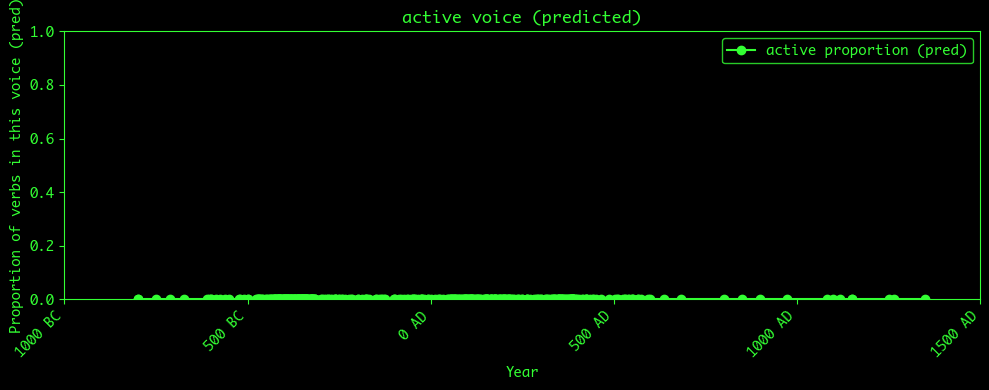

saved plot for active to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_pred_voice_proportion_active.png


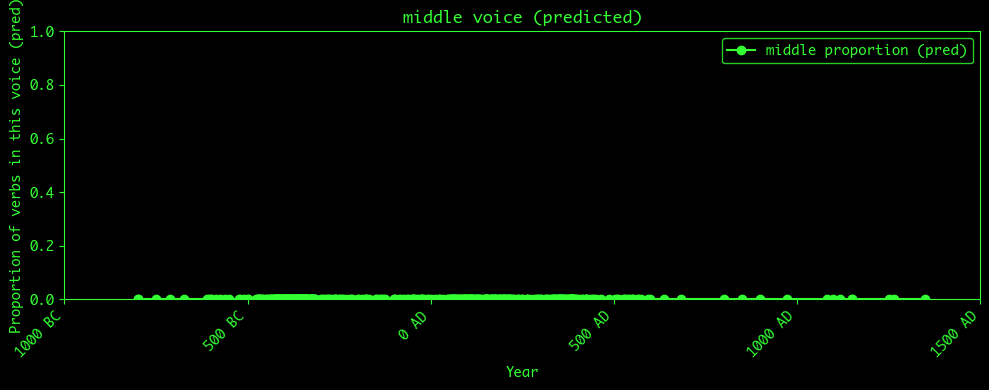

saved plot for middle to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_pred_voice_proportion_middle.png


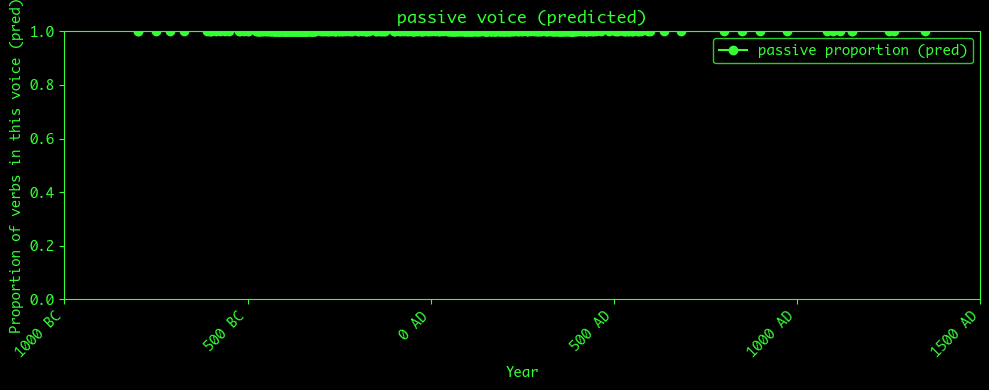

saved plot for passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_pred_voice_proportion_passive.png


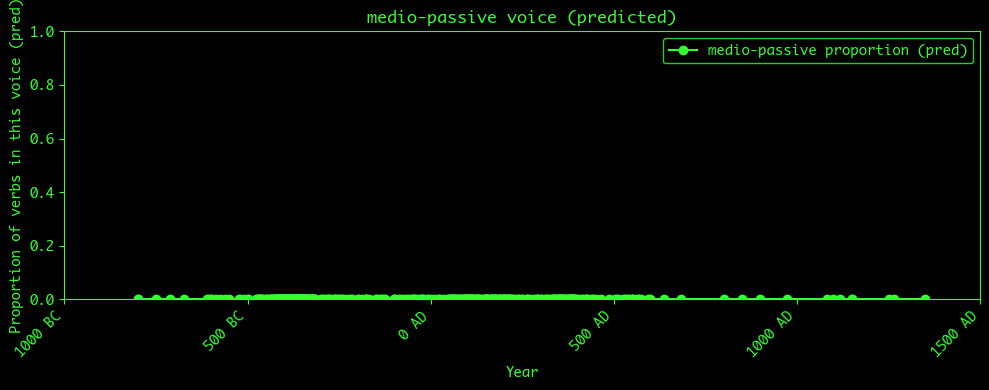

saved plot for medio-passive to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_pred_voice_proportion_medio-passive.png


In [65]:
# Plot predicted voice proportions over time with trend lines and save one PNG per voice.

# Keep only rows with a usable date and predicted voice.
df_pred = verb_df_pred.dropna(subset=["year_mid", "pred_voice_name"]).copy()
df_pred["year_mid"] = df_pred["year_mid"].astype(float)

# Total predicted verbs per year across all voices.
totals_by_year = (
    df_pred.groupby("year_mid", dropna=False)
    .size()
    .reset_index(name="total_count")
)

# Fixed voice order.
voice_order = ["active", "middle", "passive", "medio-passive"]

# Monospace font and black background style.
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Monaco", "Courier", "Courier New", "DejaVu Sans Mono"]

# Common list of years on the x axis.
all_years = sorted(df_pred["year_mid"].unique())
year_frame = pd.DataFrame({"year_mid": all_years})

for voice in voice_order:
    # Counts for this voice per year.
    df_voice = df_pred[df_pred["pred_voice_name"] == voice]
    counts = (
        df_voice.groupby("year_mid", dropna=False)
        .size()
        .reset_index(name="voice_count")
    )

    # Join with totals and compute proportions.
    joined = year_frame.merge(totals_by_year, on="year_mid", how="left")
    joined = joined.merge(counts, on="year_mid", how="left")
    joined["voice_count"] = joined["voice_count"].fillna(0.0)
    joined["total_count"] = joined["total_count"].fillna(0.0)
    joined["proportion"] = 0.0
    nonzero = joined["total_count"] > 0
    joined.loc[nonzero, "proportion"] = (
        joined.loc[nonzero, "voice_count"] / joined.loc[nonzero, "total_count"]
    )

    x = joined["year_mid"].to_numpy(dtype=float)
    y = joined["proportion"].to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=(10, 4))

    fig.patch.set_facecolor("#000000")
    ax.set_facecolor("#000000")

    ax.plot(
        x,
        y,
        marker="o",
        linestyle="-",
        color="#33FF33",
        label=f"{voice} proportion (pred)",
    )

    if len(x) >= 2 and np.any(y != y[0]):
        coeffs = np.polyfit(x, y, 1)
        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = coeffs[0] * x_fit + coeffs[1]
        ax.plot(
            x_fit,
            y_fit,
            linestyle="-",
            color="#FF33FF",
            label="trend line #FF33FF",
        )

    for spine in ax.spines.values():
        spine.set_color("#33FF33")

    ax.tick_params(colors="#33FF33")

    ticks = ax.get_xticks()
    labels = []
    for t in ticks:
        year = int(round(t))
        if year < 0:
            labels.append(f"{abs(year)} BC")
        else:
            labels.append(f"{year} AD")

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha="right", color="#33FF33")

    ax.set_ylim(0.0, 1.0)

    ax.set_xlabel("Year", color="#33FF33")
    ax.set_ylabel("Proportion of verbs in this voice (pred)", color="#33FF33")
    ax.set_title(f"{voice} voice (predicted)", color="#33FF33")

    legend = ax.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor("#000000")
    frame.set_edgecolor("#33FF33")
    for text in legend.get_texts():
        text.set_color("#33FF33")

    plt.tight_layout()

    out_path = data_dir / f"verb_pred_voice_proportion_{voice}.png"
    fig.savefig(
        out_path,
        dpi=300,
        facecolor=fig.get_facecolor(),
        bbox_inches="tight",
    )

    plt.show()
    print("saved plot for", voice, "to", out_path)


#### matplotlib pivot table verb voice proportional — all four voices

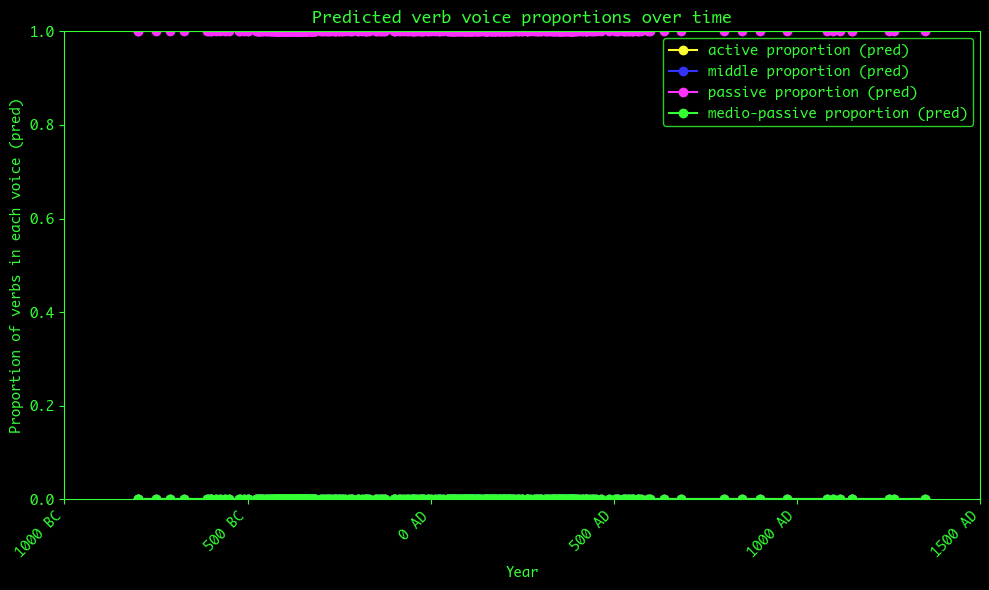

saved combined predicted plot to /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/verb_pred_voice_proportions_all_voices.png


In [66]:
# Plot predicted voice proportions for all voices on one graph and save a combined PNG.

df_pred_all = verb_df_pred.dropna(subset=["year_mid", "pred_voice_name"]).copy()
df_pred_all["year_mid"] = df_pred_all["year_mid"].astype(float)

totals_by_year_all = (
    df_pred_all.groupby("year_mid", dropna=False)
    .size()
    .reset_index(name="total_count")
)

voice_order = ["active", "middle", "passive", "medio-passive"]
all_years_all = sorted(df_pred_all["year_mid"].unique())
base_years = pd.DataFrame({"year_mid": all_years_all})

series_by_voice = {}

for voice in voice_order:
    subset = df_pred_all[df_pred_all["pred_voice_name"] == voice]
    counts = (
        subset.groupby("year_mid", dropna=False)
        .size()
        .reset_index(name="voice_count")
    )

    merged = base_years.merge(totals_by_year_all, on="year_mid", how="left")
    merged = merged.merge(counts, on="year_mid", how="left")
    merged["voice_count"] = merged["voice_count"].fillna(0.0)
    merged["total_count"] = merged["total_count"].fillna(0.0)
    merged["proportion"] = 0.0
    nz = merged["total_count"] > 0
    merged.loc[nz, "proportion"] = (
        merged.loc[nz, "voice_count"] / merged.loc[nz, "total_count"]
    )

    series_by_voice[voice] = merged["proportion"].to_numpy(dtype=float)

x_all = base_years["year_mid"].to_numpy(dtype=float)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Monaco", "Courier", "Courier New", "DejaVu Sans Mono"]

fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_facecolor("#000000")
ax.set_facecolor("#000000")

voice_colors = {
    "active": "#FFFF33",
    "middle": "#3333FF",
    "passive": "#FF33FF",
    "medio-passive": "#33FF33",
}

for voice in voice_order:
    y_all = series_by_voice.get(voice)
    if y_all is None:
        y_all = np.zeros_like(x_all, dtype=float)
    color = voice_colors.get(voice, "#33FF33")
    ax.plot(
        x_all,
        y_all,
        marker="o",
        linestyle="-",
        color=color,
        label=f"{voice} proportion (pred)",
    )

for spine in ax.spines.values():
    spine.set_color("#33FF33")

ax.tick_params(colors="#33FF33")

ticks = ax.get_xticks()
labels = []
for t in ticks:
    year = int(round(t))
    if year < 0:
        labels.append(f"{abs(year)} BC")
    else:
        labels.append(f"{year} AD")

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha="right", color="#33FF33")

ax.set_ylim(0.0, 1.0)

ax.set_xlabel("Year", color="#33FF33")
ax.set_ylabel("Proportion of verbs in each voice (pred)", color="#33FF33")
ax.set_title("Predicted verb voice proportions over time", color="#33FF33")

legend = ax.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor("#000000")
frame.set_edgecolor("#33FF33")
for text in legend.get_texts():
    text.set_color("#33FF33")

plt.tight_layout()

out_path = data_dir / "verb_pred_voice_proportions_all_voices.png"
fig.savefig(
    out_path,
    dpi=300,
    facecolor=fig.get_facecolor(),
    bbox_inches="tight",
)

plt.show()
print("saved combined predicted plot to", out_path)


## Debug

### Debug extraction

In [71]:
tsv_path = data_dir / "oga_verbs_voice_metadata.tsv"
verb_df_raw = pd.read_csv(tsv_path, sep="\t")
print(verb_df_raw["voice"].value_counts(dropna=False))
print(verb_df_raw["voice_label"].value_counts(dropna=False))

voice
active           4052413
medio-passive    1324812
middle            380105
passive           253200
NaN                72604
Name: count, dtype: int64
voice_label
 0    4052413
 3    1324812
 1     380105
 2     253200
-1      72604
Name: count, dtype: int64


### Debug build X y

In [72]:
# 1. Basic size check on prediction frame.
print("verb_df_clean rows:", len(verb_df_clean))
print("verb_df_pred rows:", len(verb_df_pred))

# 2. How many rows survive the year_mid / pred_voice_name filter.
df_pred = verb_df_pred.dropna(subset=["year_mid", "pred_voice_name"]).copy()
print("df_pred rows after dropna:", len(df_pred))

# 3. Quick year and voice distribution to confirm non-emptiness.
print("unique years in df_pred:", df_pred["year_mid"].nunique())
print("predicted voice distribution in df_pred:")
print(df_pred["pred_voice_name"].value_counts(dropna=False))


verb_df_clean rows: 6010530
verb_df_pred rows: 6010530
df_pred rows after dropna: 5816800
unique years in df_pred: 449
predicted voice distribution in df_pred:
pred_voice_name
passive    5816800
Name: count, dtype: int64


In [73]:
print("tsv_path:", tsv_path)
print("X_out:", data_dir / "X_verb_features.npy")
print("y_out:", data_dir / "y_voice_labels.npy")

tsv_path: /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/oga_verbs_voice_metadata.tsv
X_out: /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/X_verb_features.npy
y_out: /Users/admin/Desktop/Opera_Graeca_Verb_Parser/data/y_voice_labels.npy


### Debug training

In [74]:
# Inspect labels in the cleaned training table.
print("voice_label in verb_df_clean")
print(verb_df_clean["voice_label"].value_counts(dropna=False))

print("\nvoice in verb_df_clean")
print(verb_df_clean["voice"].value_counts(dropna=False))


voice_label in verb_df_clean
voice_label
0    4052413
3    1324812
1     380105
2     253200
Name: count, dtype: int64

voice in verb_df_clean
voice
active           4052413
medio-passive    1324812
middle            380105
passive           253200
Name: count, dtype: int64


In [75]:
# Inspect predicted labels and names after inference.
print("pred_voice_label in verb_df_pred")
print(verb_df_pred["pred_voice_label"].value_counts(dropna=False))

print("\npred_voice_name in verb_df_pred")
print(verb_df_pred["pred_voice_name"].value_counts(dropna=False))


pred_voice_label in verb_df_pred
pred_voice_label
2    6010530
Name: count, dtype: int64

pred_voice_name in verb_df_pred
pred_voice_name
passive    6010530
Name: count, dtype: int64


### Debug model predicted plots

In [57]:
# Quick check that the predicted plotting input sees all four names.
print("unique pred_voice_name in plotting frame")
df_pred = verb_df_pred.dropna(subset=["year_mid", "pred_voice_name"]).copy()
print(sorted(df_pred["pred_voice_name"].unique()))


unique pred_voice_name in plotting frame
['active', 'medio-passive', 'middle']


### ?

In [ ]:
print("hello world")

In [ ]:
X = np.random.randn(6,100)
print(X)

In [ ]:
y = np.random.randn(100,1)
y = y > 0.1

In [ ]:
print(y)